In [147]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFECV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
import seaborn as sns

In [148]:
het_cyto_data = pd.read_csv('../data/het_cyto_data.tsv', sep='\t', index_col=0)
c = list(het_cyto_data.iloc[:,:-2].columns + '_fc')
c.extend(['mean_het_lvl', 'disease'])
het_cyto_data.columns = c
alpha_div = pd.read_csv('../data/alpha-div.tsv', sep='\t', index_col=0)
anamnesis = pd.read_csv('../data/anamnesis.csv', index_col=0)
het_cyto_data['q=1'] = alpha_div['q=1'].reindex(het_cyto_data.index)
het_cyto_data['BMI'] = anamnesis['ИМТ'].reindex(het_cyto_data.index)
het_cyto_data['glucose'] = anamnesis['ГЛ'].reindex(het_cyto_data.index)
het_cyto_data['fats_high'] = anamnesis['ЛПВП'].reindex(het_cyto_data.index)
het_cyto_data['fats_low'] = anamnesis['ЛПНП'].reindex(het_cyto_data.index)
het_cyto_data['IA'] = anamnesis['ИА'].reindex(het_cyto_data.index) # индекс атерогенности

In [149]:
expression = pd.read_csv('../data/expression.tsv', sep='\t', index_col='Samples')
expression = expression.dropna()
# log2 all the expressions
expression.iloc[:,:-2] = np.log2(expression.iloc[:,:-2])
expression.columns += '_exp'

In [150]:
het_cyto_exp = het_cyto_data.join(expression, how='inner')
het_cyto_exp

,IL-6_fc,MCP-1_fc,IL-1b_fc,TNF-a_fc,IL-10_fc,IL-8_fc,mean_het_lvl,disease,q=1,BMI,...,MT-CYB_exp,MT-ND1_exp,MT-ND4_exp,MT-RNR1_exp,MT-RNR2_exp,DRP1_exp,MFN2_exp,NFE2L2_exp,OPA1_exp,TFAM_exp
5,220.947754,43.464305,2.795976,307.813620,75.573990,8.518603,0.095706,1,3.000000,27.6,...,-0.935117,0.471031,1.645702,0.963696,0.565890,1.578886,-1.086017,0.246870,0.34474,3.42678
6,99.129891,12.545548,1.970814,12.892022,14.675090,157.289657,0.371491,1,2.871746,43.7,...,-0.646112,0.292311,1.584000,0.762987,0.547845,1.145377,-0.339272,0.134063,0.00088,2.77998
7,71.148681,3.026672,2.425959,24.003158,23.084995,1.000000,0.089496,1,3.000000,38.8,...,3.277985,0.888772,0.985136,0.932968,1.256467,1.272095,-1.667172,0.999668,1.92792,3.83777
11,20.000000,1.215848,3.190663,24.434444,24.109061,1.000000,0.448596,1,2.600490,34.3,...,0.731183,-1.147522,-1.895395,-1.104387,-0.654944,-0.308930,-0.904467,1.078063,1.78225,0.81731
27,412.888465,11.685180,5.505951,41.587768,344.189944,8.995548,0.088332,1,3.000000,43.7,...,-1.498179,-0.349971,0.623867,0.321351,-0.011879,0.236499,0.485623,-0.157592,3.43077,1.24666
31,158.174432,11.314378,4.322621,72.791282,79.709176,1.813686,0.090535,1,3.000000,34.9,...,-1.325539,0.409798,1.313072,0.252173,-0.070360,1.476107,-2.263889,-0.392270,2.56579,2.54013
50,291.934273,6.798614,6.176347,62.481581,168.681592,4.222795,0.085447,1,3.000000,33.7,...,-3.279284,-0.689195,-0.944249,-2.272994,-2.348133,-3.263819,-1.316708,-2.689195,7.08545,0.19789
56,922.715137,10.856726,1.760053,21.425397,4.572238,5.086714,0.094534,0,3.000000,41.2,...,-2.708396,-0.609773,-1.163914,-1.353653,-0.951764,-0.368309,-0.003047,-2.372505,38.03884,0.51497
74,109.979028,99.910137,29.947730,307.689081,35.054971,10.000000,0.397984,1,2.586409,40.5,...,-1.343732,0.076833,0.581303,-0.089421,-0.248108,0.639019,1.441733,1.659715,0.00233,1.40563
82,1556.935201,5.911950,3.098217,46.277999,10.820888,25.724576,0.079552,1,2.828427,32.9,...,-2.101598,-0.106715,-0.154570,2.773279,-0.795108,0.310177,1.794774,-1.149633,27.33593,0.40023


In [151]:
X = het_cyto_exp.drop('disease', axis=1)
y = het_cyto_exp['disease']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
print(f"Before SMOTE: Class 0: {sum(y == 0)}, Class 1: {sum(y == 1)}")
print(f"After SMOTE: Class 0: {sum(y_resampled == 0)}, Class 1: {sum(y_resampled == 1)}")

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, stratify=y_resampled, test_size=0.2)

param_grid_improved = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5, 0.8],
    'bootstrap': [True, False]
}


random_search = RandomizedSearchCV(
    RandomForestClassifier(class_weight='balanced'),
    param_grid_improved,
    n_iter=100,
    cv=10,
    scoring='roc_auc',
    n_jobs=-1
)

random_search.fit(X_train, y_train)
print("Best score:", random_search.best_score_)
print("Best params:", random_search.best_params_)

model = random_search.best_estimator_

Before SMOTE: Class 0: 21, Class 1: 12
After SMOTE: Class 0: 21, Class 1: 21
Best score: 1.0
Best params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 5, 'bootstrap': False}


Feature Importance:
         feature  importance
8            BMI    0.210277
12            IA    0.116117
10     fats_high    0.104154
1       MCP-1_fc    0.098081
9        glucose    0.047843
13    NFKBIA_exp    0.043359
5        IL-8_fc    0.038335
14       p65_exp    0.037485
17      SOD2_exp    0.031575
3       TNF-a_fc    0.026836
25      MFN2_exp    0.025410
21    MT-ND4_exp    0.023700
6   mean_het_lvl    0.022177
11      fats_low    0.019215
23   MT-RNR2_exp    0.017645


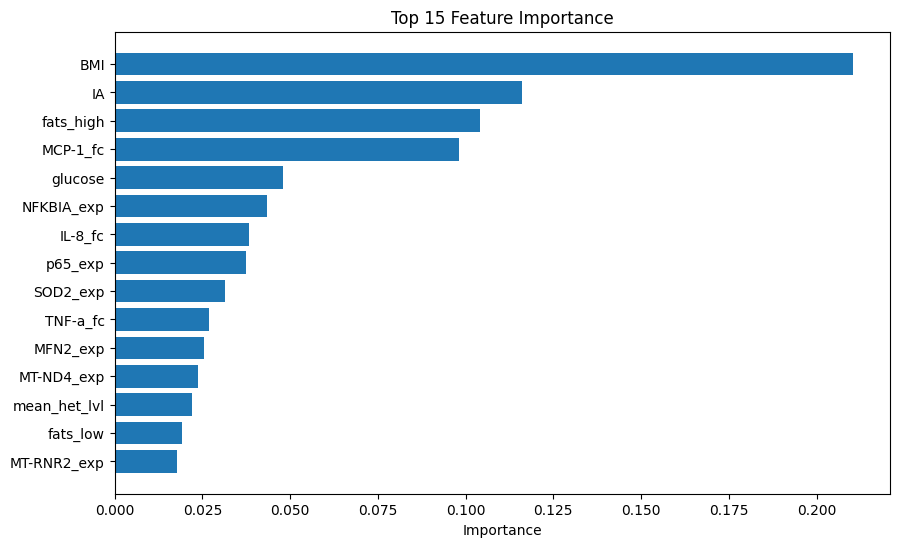

In [152]:
feature_importance = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Feature Importance:")
print(feature_importance_df.head(15))


plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'][:15], feature_importance_df['importance'][:15])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importance')
plt.gca().invert_yaxis()
plt.show()